### Decision Time of Human-AI Decision / Human Decision - By Reliance Groups and XAI condition

In [ ]:
import pandas as pd

reliance_data = pd.read_csv('gaze_data/reliance_groups/groups.csv')

# remove 'O23' or user == 'OX30' from the dataset
reliance_data = reliance_data[~reliance_data['ID'].isin(['O23', 'OX30'])]

time_data = pd.read_csv('mushroom_data/task-times-by-decision.csv')

# human-ai decision time is timestamp (end_human_ai_ai_ai_ai_decision - end_human_decision_time)
# human decision time is (end_human_decision_time - feedback) or (end_human_decision_time - tutorial_task)

# for every click_start, remove the rows between click_start and tutorial_task

# obtain all indexes of click_start
click_start_indexes = time_data[time_data['event'] == 'click_start'].index
# obtain all indexes of tutorial_task
tutorial_task_indexes = time_data[time_data['event'] == 'tutorial_task'].index

print (click_start_indexes)
print (tutorial_task_indexes)

# save time_data to a new DataFrame and remove the rows between click_start and tutorial_task
filtered_df = time_data.copy()
# drop all rows between click_start and tutorial_task indexes
for i in range(len(click_start_indexes)):
    start_index = click_start_indexes[i]
    end_index = tutorial_task_indexes[i]
    filtered_df.drop(index = range(start_index, end_index), inplace=True)
# Reset index after dropping rows
filtered_df = filtered_df.reset_index(drop=True)

# save the filtered data
filtered_df.to_csv('mushroom_data/filtered_task_times.csv', index=False)
time_data = pd.read_csv('mushroom_data/filtered_task_times.csv')

def get_XAI(idd):
    if 'X' in idd:
        return 1
    else:
        return 0

def get_spss_data(tracker_results):
    tracker_results['XAI_value'] = tracker_results['ID'].apply(get_XAI)

def get_human_decision_time(row):
    # the row is either feedback or tutorial_task, so we need to get the time of the next row
    # (end_human_decision)
    next_row = time_data.iloc[i+1]
    decision_time = next_row['timestamp'] - row['timestamp'] 
    return decision_time

def get_human_ai_decision_time(row):
    # the row is end_human_decision, so we need to get the time of the next row (end_human_ai_decision)
    next_row = time_data.iloc[i+1]
    decision_time = next_row['timestamp'] - row['timestamp']
    return decision_time

ids = []
human_ai_decision_times = []
human_decision_times = []
tasks = []
task = 1
previous_id = time_data.iloc[0]['ID']
print('Previous ID', previous_id)
print(len(time_data))
# Loop through the data
for i in range(0, len(time_data)-1):
    row = time_data.iloc[i]
    current_id = row['ID']  # current user ID
    # check for human decision time - 1st task of 1st user
    if row['event'] == 'tutorial_task' and current_id == previous_id:
        human_decision_time = get_human_decision_time(row)
        human_decision_times.append(human_decision_time)
        print('Initial: ', task)
    # check for human decision time - subsequent tasks until the last task
    elif row['event'] == 'feedback' and current_id == previous_id and current_id == time_data.iloc[i+1]['ID']:
        human_decision_time = get_human_decision_time(row)
        human_decision_times.append(human_decision_time)    
        task += 1
        print('Human Task: ', task)
    elif row['event'] == 'tutorial_task' and current_id != previous_id:
        human_decision_time = get_human_decision_time(row)
        human_decision_times.append(human_decision_time)
        task = 1
        print('New User: ', task)
    # check for human-ai decision
    elif row['event'] == 'end_human_decision':
        human_ai_decision_time = get_human_ai_decision_time(row)
        human_ai_decision_times.append(human_ai_decision_time)
        ids.append(current_id)
        tasks.append(task)
        print('Task Human-AI: ',  task)
    else:
        continue
    previous_id = current_id

print(len(ids))
print(len(tasks))
print(len(human_decision_times))
print(len(human_ai_decision_times))

# create a new DataFrame with the collected data
output_df = pd.DataFrame({
    'ID': ids,
    'task': tasks,
    'human_decision_time': human_decision_times,
    'human_ai_decision_time': human_ai_decision_times
})

# XAI value
get_spss_data(output_df)
output_df.to_csv('mushroom_data/decision_times.csv', index=False)

### Obtain Global results of Decision Time by XAI Condition

{'human_decision_time_mean_0': 25.59111111111111, 'human_decision_time_sem_0': 1.0901105068329466, 'human_ai_decision_time_mean_0': 6.1866666666666665, 'human_ai_decision_time_sem_0': 0.3815215985481427, 'human_decision_time_mean_1': 19.537777777777777, 'human_decision_time_sem_1': 0.6429706738864177, 'human_ai_decision_time_mean_1': 19.595555555555556, 'human_ai_decision_time_sem_1': 0.764336463396125}


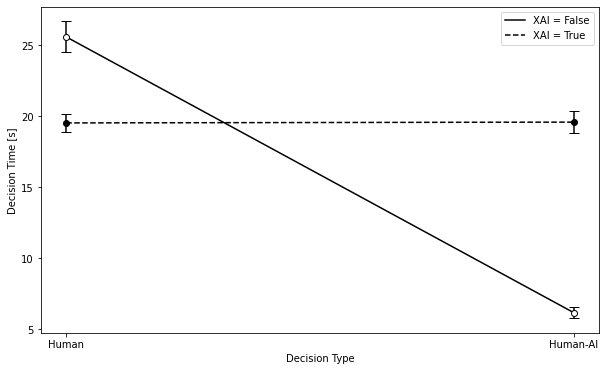

In [86]:
# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem


results_xai = {
    "human_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_ai_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_ai_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time')
}

print(results_xai)
# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_global_results.csv', index=False)


import matplotlib.pyplot as plt

ai_decision_o = results_xai['human_ai_decision_time_mean_0']
ai_decision_ox = results_xai['human_ai_decision_time_mean_1']
ai_decision_o_sem = results_xai['human_ai_decision_time_sem_0']
ai_decision_ox_sem = results_xai['human_ai_decision_time_sem_1']

human_decision_o = results_xai['human_decision_time_mean_0']
human_decision_ox = results_xai['human_decision_time_mean_1']
human_decision_o_sem = results_xai['human_decision_time_sem_0']
human_decision_ox_sem = results_xai['human_decision_time_sem_1']

positions = [0, 10]
labels = ['Human', 'Human-AI']
y_index = [0, 10]
    
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, [human_decision_o, ai_decision_o], [human_decision_o_sem, ai_decision_o_sem], color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, [human_decision_ox, ai_decision_ox], [human_decision_ox_sem, ai_decision_ox_sem], markeredgecolor = 'black', color='black', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')

handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)

plt.ylabel('Decision Time [s]')
plt.xlabel('Decision Type')
plt.xticks(positions, labels)
# plt.title('Elmo Fixation Count')
plt.savefig('mushroom_results/decision_times_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()





### Normalized by Human Decision Time


{'human_decision_time_mean_0': 25.59111111111111, 'human_decision_time_sem_0': 1.0901105068329466, 'human_ai_decision_time_mean_0': 6.1866666666666665, 'human_ai_decision_time_sem_0': 0.3815215985481427, 'human_decision_time_mean_1': 19.537777777777777, 'human_decision_time_sem_1': 0.6429706738864177, 'human_ai_decision_time_mean_1': 19.595555555555556, 'human_ai_decision_time_sem_1': 0.764336463396125}


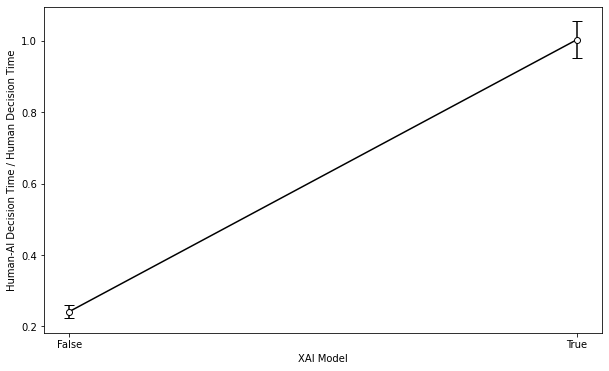

In [29]:
# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem


results_xai = {
    "human_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_ai_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_ai_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time')
}

print(results_xai)
# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_global_results.csv', index=False)


import matplotlib.pyplot as plt

ai_decision_o = results_xai['human_ai_decision_time_mean_0']
ai_decision_ox = results_xai['human_ai_decision_time_mean_1']
ai_decision_o_sem = results_xai['human_ai_decision_time_sem_0']
ai_decision_ox_sem = results_xai['human_ai_decision_time_sem_1']

human_decision_o = results_xai['human_decision_time_mean_0']
human_decision_ox = results_xai['human_decision_time_mean_1']
human_decision_o_sem = results_xai['human_decision_time_sem_0']
human_decision_ox_sem = results_xai['human_decision_time_sem_1']

positions = [0, 10]
labels = ['False', 'True']
y_index = [0, 10]

# SEM of ratio X/Y = sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y

sem_normalized_o = ai_decision_o*np.sqrt((human_decision_o_sem/human_decision_o)**2 + (ai_decision_o_sem/ai_decision_o)**2)/human_decision_o
sem_normalized_ox = ai_decision_ox*np.sqrt((human_decision_ox_sem/human_decision_ox)**2 + (ai_decision_ox_sem/ai_decision_ox)**2)/human_decision_ox

plt.figure(figsize=(10, 6))
plt.errorbar(y_index, [ai_decision_o/human_decision_o, ai_decision_ox/human_decision_ox], [sem_normalized_o, sem_normalized_ox], color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')

plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
# plt.title('Elmo Fixation Count')
plt.savefig('mushroom_results/normalized_decision_times_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()



### Normalized by mean and STD


{'human_decision_time_mean_0': 25.59111111111111, 'human_decision_time_sem_0': 1.0901105068329466, 'human_decision_time_std_0': 16.3516576024942, 'human_ai_decision_time_mean_0': 6.1866666666666665, 'human_ai_decision_time_sem_0': 0.3815215985481427, 'human_ai_decision_time_std_0': 5.722823978222141, 'human_decision_time_mean_1': 19.537777777777777, 'human_decision_time_sem_1': 0.6429706738864177, 'human_decision_time_std_1': 9.644560108296266, 'human_ai_decision_time_mean_1': 19.595555555555556, 'human_ai_decision_time_sem_1': 0.764336463396125, 'human_ai_decision_time_std_1': 11.465046950941876}


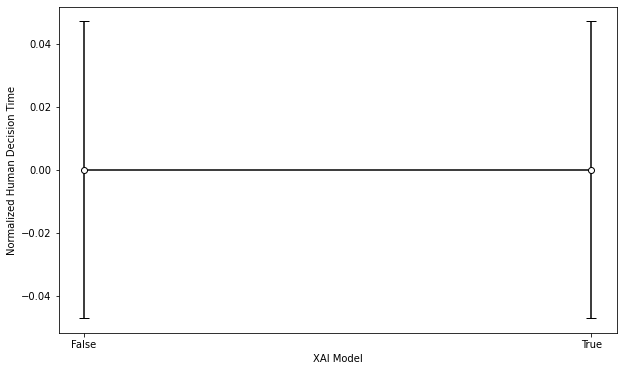

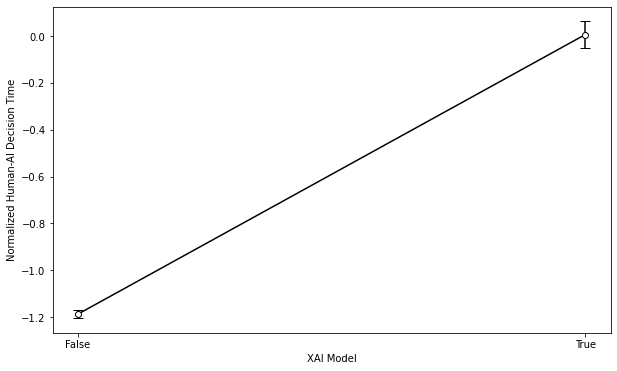

In [133]:
# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem
def std(df, column):
    std = df[column].std(ddof=1)
    return std

results_xai = {
    "human_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_std_0": std(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_ai_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_ai_decision_time_std_0": std(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_std_1": std(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_ai_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time'),
    "human_ai_decision_time_std_1": std(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time')
}
print(results_xai)
# save the results to a csv file
results_df = pd.DataFrame([results_xai])
results_df.to_csv('mushroom_data/decision_times_global_results.csv', index=False)

def normalize(df, column, mean, std):
    normalized = (df[column] - mean)/std
    return normalized

# for all users, normalize the decision times by the mean human decision time and std human decision time
normalized_results = decision_data.copy()
normalized_results['normalized_human_decision_time_o'] = normalize(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time', np.array(results_xai['human_decision_time_mean_0']), np.array(results_xai['human_decision_time_std_0']))
normalized_results['normalized_human_decision_time_ox'] = normalize(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time', np.array(results_xai['human_decision_time_mean_1']), np.array(results_xai['human_decision_time_std_1']))
normalized_results['normalized_human_ai_decision_time_o'] = normalize(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time', np.array(results_xai['human_decision_time_mean_0']), np.array(results_xai['human_decision_time_std_0']))
normalized_results['normalized_human_ai_decision_time_ox'] = normalize(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time', np.array(results_xai['human_decision_time_mean_1']), np.array(results_xai['human_decision_time_std_1']))

# convert dict to DataFrame
normalized_results = pd.DataFrame(normalized_results)
normalized_results.to_csv('mushroom_data/decision_times_normalized.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = results_xai['human_ai_decision_time_mean_0']
ai_decision_ox = results_xai['human_ai_decision_time_mean_1']
ai_decision_o_sem = results_xai['human_ai_decision_time_sem_0']
ai_decision_ox_sem = results_xai['human_ai_decision_time_sem_1']
ai_decision_o_std = results_xai['human_ai_decision_time_std_0']
ai_decision_ox_std = results_xai['human_ai_decision_time_std_1']

human_decision_o = results_xai['human_decision_time_mean_0']
human_decision_ox = results_xai['human_decision_time_mean_1']
human_decision_o_sem = results_xai['human_decision_time_sem_0']
human_decision_ox_sem = results_xai['human_decision_time_sem_1']
human_decision_o_std = results_xai['human_decision_time_std_0']
human_decision_ox_std = results_xai['human_decision_time_std_1']

positions = [0, 10]
labels = ['False', 'True']
y_index = [0, 10]

normalized_mean_ai_decision_o = mean(normalized_results, 'normalized_human_ai_decision_time_o')
normalized_mean_ai_decision_ox = mean(normalized_results, 'normalized_human_ai_decision_time_ox')
normalized_sem_ai_decision_o = sem(normalized_results, 'normalized_human_ai_decision_time_o')
normalized_sem_ai_decision_ox = sem(normalized_results, 'normalized_human_ai_decision_time_ox')

normalized_mean_human_decision_o = mean(normalized_results, 'normalized_human_decision_time_o')
normalized_mean_human_decision_ox = mean(normalized_results, 'normalized_human_decision_time_ox')
normalized_sem_human_decision_o = sem(normalized_results, 'normalized_human_decision_time_o')
normalized_sem_human_decision_ox = sem(normalized_results, 'normalized_human_decision_time_ox')


plt.figure(figsize=(10, 6))
plt.errorbar(y_index, [normalized_mean_human_decision_o, normalized_mean_human_decision_ox],[normalized_sem_human_decision_o, normalized_sem_human_decision_ox] , color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Normalized Human Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('mushroom_results/mean_std_human_decision_times_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
plt.errorbar(y_index, [normalized_mean_ai_decision_o, normalized_mean_ai_decision_ox],[normalized_sem_ai_decision_o, normalized_sem_ai_decision_ox] , color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Normalized Human-AI Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
# plt.title('Elmo Fixation Count')
plt.savefig('mushroom_results/mean_std_ai_decision_times_boxplot.png', dpi = 1600, bbox_inches='tight')


plt.show()




### Time plot of XAI = True and False from Task 1- 15


0     13
1     16
2     10
3     11
4     15
5     13
6     13
7     11
8     18
9     15
10    12
11    17
12    12
13    13
14     8
Name: xai_duration, dtype: int64


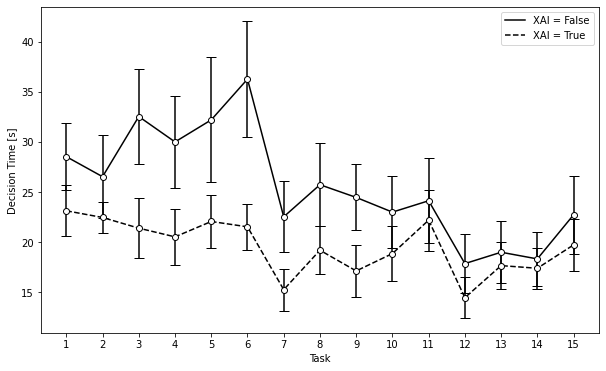

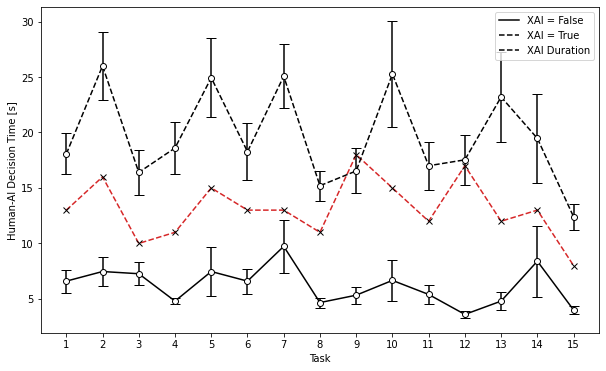

In [101]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, human_decision_o, human_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, human_decision_ox, human_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('mushroom_results/human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
xai_durations = pd.read_csv('gaze_data/XAI_durations.csv')
xai_durations = xai_durations['xai_duration']
print(xai_durations)
plt.errorbar(y_index, ai_decision_o, ai_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, ai_decision_ox, ai_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Human-AI Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)

plt.plot(y_index, xai_durations, color='tab:red', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', marker = 'x')

handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI Duration'),
    ]

plt.legend(handles=handles)
plt.savefig('mushroom_results/human_ai_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()










### Normalized Time plot by Global Human Decision Time in (XAI condition)


Normalized XAI Durations:  [0.57612763 0.70908017 0.4431751  0.48749261 0.66476266 0.57612763
 0.57612763 0.48749261 0.79771519 0.66476266 0.53181012 0.75339768
 0.53181012 0.57612763 0.35454008]
AI-Decision Normalized:  [0.25790205 0.29176797 0.28395276 0.18756513 0.29176797 0.25790205
 0.3803404  0.18235498 0.2084057  0.26050712 0.21101077 0.14067385
 0.18756513 0.32823897 0.15630427]
AI-Decision Normalized OX:  [0.92470428 1.33075523 0.83939945 0.95200182 1.27616015 0.93494086
 1.28298453 0.77797998 0.84622384 1.29322111 0.87010919 0.89740673
 1.18744313 0.99636033 0.63466788]
[0.04179135 0.05193676 0.04151694 0.01405792 0.08873826 0.04577698
 0.09499328 0.01899683 0.03123434 0.07276911 0.0348164  0.01389116
 0.03359064 0.12551026 0.01574556]
[0.09972181 0.1626903  0.10867695 0.12538602 0.18576611 0.13618977
 0.15346081 0.07382934 0.1075886  0.24617821 0.11388723 0.12027591
 0.20951411 0.20918954 0.06363108]


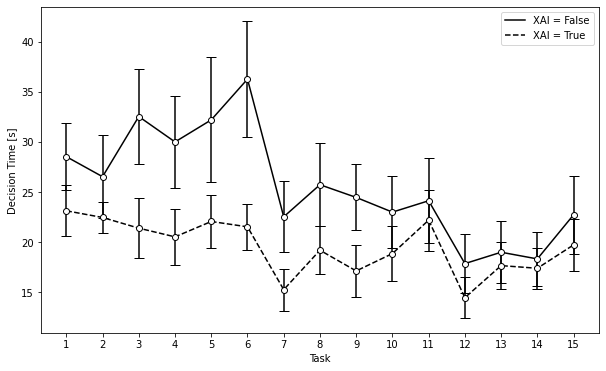

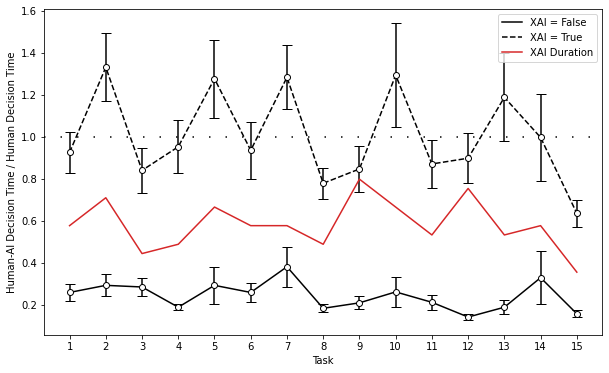

In [31]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, human_decision_o, human_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, human_decision_ox, human_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('mushroom_results/human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
xai_durations = pd.read_csv('gaze_data/XAI_durations.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')
global_human_decision_o = global_results['human_decision_time_mean_0']
global_human_decision_ox = global_results['human_decision_time_mean_1']
global_human_decision_o_sem = global_results['human_decision_time_sem_0']
global_human_decision_ox_sem = global_results['human_decision_time_sem_1']

xai_durations = xai_durations['xai_duration']
xai_durations = np.array(xai_durations)
normalized_human_decision = (global_human_decision_o+global_human_decision_ox)/2
normalized_human_decision = np.array(normalized_human_decision)
normalized_xai_durations = xai_durations/normalized_human_decision
print('Normalized XAI Durations: ', normalized_xai_durations)

# convert to numpy array

ai_decision_o = np.array(ai_decision_o)
ai_decision_ox = np.array(ai_decision_ox)
global_human_decision_o = np.array(global_human_decision_o)
global_human_decision_ox = np.array(global_human_decision_ox)
global_human_decision_o_sem = np.array(global_human_decision_o_sem)
global_human_decision_ox_sem = np.array(global_human_decision_ox_sem)

normalized_ai_decision_o = ai_decision_o/global_human_decision_o
normalized_ai_decision_ox = ai_decision_ox/global_human_decision_ox
print('AI-Decision Normalized: ', normalized_ai_decision_o)
print('AI-Decision Normalized OX: ', normalized_ai_decision_ox)


# SEM = sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)
normalized_sem_o = ai_decision_o*np.sqrt((global_human_decision_o_sem/global_human_decision_o)**2 + (ai_decision_o_sem/ai_decision_o)**2)/global_human_decision_o
normalized_sem_ox = ai_decision_ox*np.sqrt((global_human_decision_ox_sem/global_human_decision_ox)**2 + (ai_decision_ox_sem/ai_decision_ox)**2)/global_human_decision_ox

print(normalized_sem_o)
print(normalized_sem_ox)

plt.errorbar(y_index, normalized_ai_decision_o, normalized_sem_o, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, normalized_ai_decision_ox, normalized_sem_ox, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('Task')
plt.xticks(positions, labels)

plt.plot(y_index, normalized_xai_durations, color='tab:red', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-')

# plot a line in y = 1
plt.axhline(y=1, color='black', linestyle=(0, (1, 10)))
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
        plt.Line2D([], [], color='tab:red', linestyle='-', label='XAI Duration'),
    ]

plt.legend(handles=handles)
plt.savefig('mushroom_results/normalized_human_ai_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()




### XAI = FALSE + XAI Duration to see if there is any difference

Normalized XAI Durations:  [0.57612763 0.70908017 0.4431751  0.48749261 0.66476266 0.57612763
 0.57612763 0.48749261 0.79771519 0.66476266 0.53181012 0.75339768
 0.53181012 0.57612763 0.35454008]
AI-Decision Normalized:  [0.25790205 0.29176797 0.28395276 0.18756513 0.29176797 0.25790205
 0.3803404  0.18235498 0.2084057  0.26050712 0.21101077 0.14067385
 0.18756513 0.32823897 0.15630427]
AI-Decision Normalized OX:  [0.92470428 1.33075523 0.83939945 0.95200182 1.27616015 0.93494086
 1.28298453 0.77797998 0.84622384 1.29322111 0.87010919 0.89740673
 1.18744313 0.99636033 0.63466788]
[0.04179135 0.05193676 0.04151694 0.01405792 0.08873826 0.04577698
 0.09499328 0.01899683 0.03123434 0.07276911 0.0348164  0.01389116
 0.03359064 0.12551026 0.01574556]
[0.09972181 0.1626903  0.10867695 0.12538602 0.18576611 0.13618977
 0.15346081 0.07382934 0.1075886  0.24617821 0.11388723 0.12027591
 0.20951411 0.20918954 0.06363108]


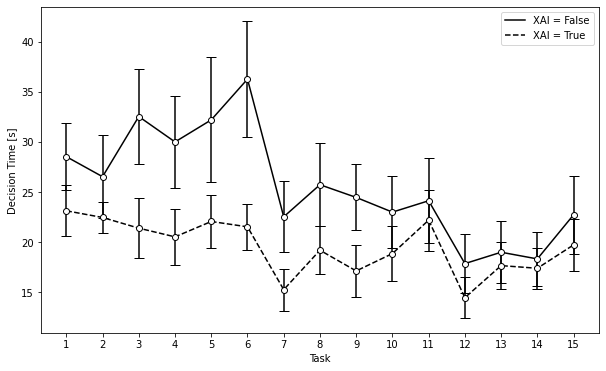

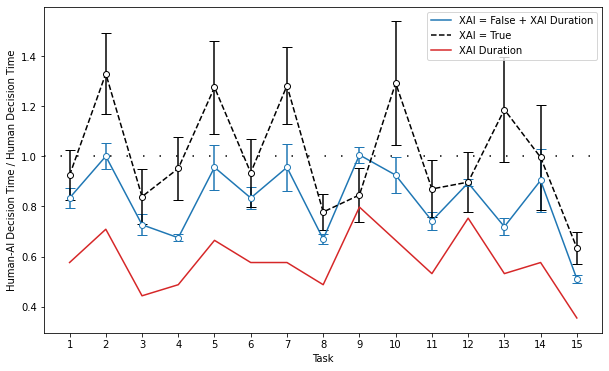

In [34]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, human_decision_o, human_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, human_decision_ox, human_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('mushroom_results/human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
xai_durations = pd.read_csv('gaze_data/XAI_durations.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')
global_human_decision_o = global_results['human_decision_time_mean_0']
global_human_decision_ox = global_results['human_decision_time_mean_1']
global_human_decision_o_sem = global_results['human_decision_time_sem_0']
global_human_decision_ox_sem = global_results['human_decision_time_sem_1']

xai_durations = xai_durations['xai_duration']
xai_durations = np.array(xai_durations)
normalized_human_decision = (global_human_decision_o+global_human_decision_ox)/2
normalized_human_decision = np.array(normalized_human_decision)
normalized_xai_durations = xai_durations/normalized_human_decision
print('Normalized XAI Durations: ', normalized_xai_durations)

# convert to numpy array

ai_decision_o = np.array(ai_decision_o)
ai_decision_ox = np.array(ai_decision_ox)
global_human_decision_o = np.array(global_human_decision_o)
global_human_decision_ox = np.array(global_human_decision_ox)
global_human_decision_o_sem = np.array(global_human_decision_o_sem)
global_human_decision_ox_sem = np.array(global_human_decision_ox_sem)

normalized_ai_decision_o = ai_decision_o/global_human_decision_o
normalized_ai_decision_ox = ai_decision_ox/global_human_decision_ox
print('AI-Decision Normalized: ', normalized_ai_decision_o)
print('AI-Decision Normalized OX: ', normalized_ai_decision_ox)


# SEM = X*sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)
normalized_sem_o = ai_decision_o*np.sqrt((global_human_decision_o_sem/global_human_decision_o)**2 + (ai_decision_o_sem/ai_decision_o)**2)/global_human_decision_o
normalized_sem_ox = ai_decision_ox*np.sqrt((global_human_decision_ox_sem/global_human_decision_ox)**2 + (ai_decision_ox_sem/ai_decision_ox)**2)/global_human_decision_ox

print(normalized_sem_o)
print(normalized_sem_ox)

plt.errorbar(y_index, normalized_ai_decision_o + normalized_xai_durations, normalized_sem_o, color='tab:blue', marker = 'o', markeredgecolor = 'tab:blue', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='tab:blue')
plt.errorbar(y_index, normalized_ai_decision_ox, normalized_sem_ox, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('Task')
plt.xticks(positions, labels)

plt.plot(y_index, normalized_xai_durations, color='tab:red', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-')

# plot a line in y = 1
plt.axhline(y=1, color='black', linestyle=(0, (1, 10)))
handles = [
        plt.Line2D([], [], color='tab:blue', linestyle='-', label='XAI = False + XAI Duration'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
        plt.Line2D([], [], color='tab:red', linestyle='-', label='XAI Duration'),
    ]

plt.legend(handles=handles)
plt.savefig('mushroom_results/normalized_addition_xai_human_ai_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()

### By Reliance groups Boxplot


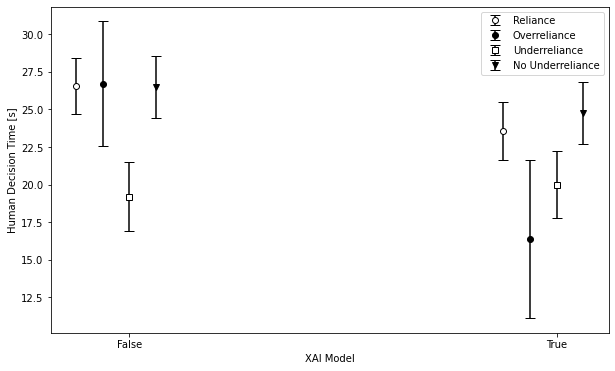

In [159]:
import numpy as np
import pandas as pd

reliance_groups = pd.read_csv('gaze_data/reliance_groups/groups.csv')
decision_data = pd.read_csv('mushroom_data/decision_times.csv')
def get_XAI(idd):
    if 'X' in idd:
        return 1
    else:
        return 0
    
reliance_groups['XAI_value'] = reliance_groups['ID'].apply(get_XAI)
# save the results to a csv file
reliance_groups.to_csv('mushroom_data/reliance_groups.csv', index=False)

merged_data = pd.merge(decision_data, reliance_groups[['ID', 'task', 'reliance', 'overreliance', 'underreliance']], on=['ID', 'task'], how='inner')

# save the results to a csv file
merged_data.to_csv('mushroom_data/decision_times_reliance_groups.csv', index=False)

def get_group(group, xai):
    if group == 'undefined':
        return 2 # undefined
    elif group == '1' and xai == 1:
        return 1 # reliance and xai = True
    elif group == '1' and xai == 0:
        return 0 # reliance and xai = False
    elif group == '0' and xai == 1:
        return 10 # no reliance and xai = True
    else:
        return 11 # no reliance and xai = False

# reliance
merged_data['condition_reliance'] = merged_data.apply(lambda row: get_group(row['reliance'], row['XAI_value']), axis=1)
# overreliance
merged_data['condition_overreliance'] = merged_data.apply(lambda row: get_group(row['overreliance'], row['XAI_value']), axis=1)
# underreliance
merged_data['condition_underreliance'] = merged_data.apply(lambda row: get_group(row['underreliance'], row['XAI_value']), axis=1)

# save the results to a csv file
merged_data.to_csv('mushroom_data/decision_times_reliance_groups.csv', index=False)

merged_data = pd.read_csv('mushroom_data/decision_times_reliance_groups.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

positions = [1.5, 9.5]
labels = ['False', 'True']

y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False
plt.errorbar(y_index, [reliance_o_mean, reliance_ox_mean],\
              [reliance_o_sem, reliance_ox_sem], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, capthick=1, ecolor='black', label = 'Reliance')

# Overreliance in XAI = True and False
plt.errorbar(y_index_2, [overreliance_o_mean, overreliance_ox_mean],\
                [overreliance_o_sem, overreliance_ox_sem], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

# Underreliance in XAI = True and False
plt.errorbar(y_index_3, [underreliance_o_mean, underreliance_ox_mean],\
                [underreliance_o_sem, underreliance_ox_sem], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

# No Underreliance in XAI = True and False
plt.errorbar(y_index_4, [no_underreliance_o_mean, no_underreliance_ox_mean],\
                [no_underreliance_o_sem, no_underreliance_ox_sem], \
             markeredgecolor = 'black', color='black', marker = 'v', ls='none', capsize=5, capthick=1, ecolor='black', label = 'No Underreliance')


plt.legend()
plt.ylabel('Human Decision Time [s]')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('reliance_images/human_decision_by_reliance_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()
















### Human AI decision time by boxplot reliance groups

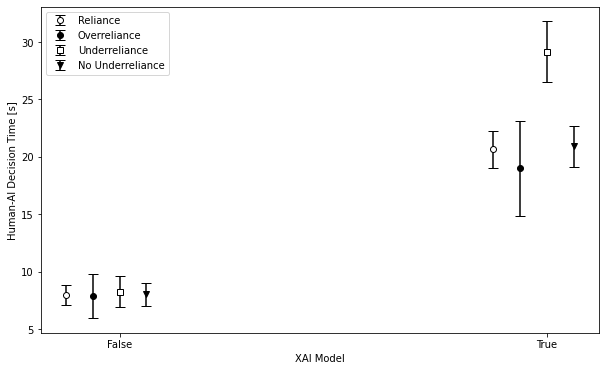

In [170]:
import numpy as np
import pandas as pd
merged_data = pd.read_csv('mushroom_data/decision_times_reliance_groups.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

# AI
reliance_o_mean_ai = mean(reliance_o, 'human_ai_decision_time')
reliance_o_sem_ai = sem(reliance_o, 'human_ai_decision_time')
reliance_ox_mean_ai = mean(reliance_ox, 'human_ai_decision_time')
reliance_ox_sem_ai = sem(reliance_ox, 'human_ai_decision_time')

overreliance_o_mean_ai = mean(overreliance_o, 'human_ai_decision_time')
overreliance_o_sem_ai = sem(overreliance_o, 'human_ai_decision_time')
overreliance_ox_mean_ai = mean(overreliance_ox, 'human_ai_decision_time')
overreliance_ox_sem_ai = sem(overreliance_ox, 'human_ai_decision_time')

underreliance_o_mean_ai = mean(underreliance_o, 'human_ai_decision_time')
underreliance_o_sem_ai = sem(underreliance_o, 'human_ai_decision_time')
underreliance_ox_mean_ai = mean(underreliance_ox, 'human_ai_decision_time')
underreliance_ox_sem_ai = sem(underreliance_ox, 'human_ai_decision_time')

no_underreliance_o_mean_ai = mean(no_underreliance_o, 'human_ai_decision_time')
no_underreliance_o_sem_ai = sem(no_underreliance_o, 'human_ai_decision_time')
no_underreliance_ox_mean_ai = mean(no_underreliance_ox, 'human_ai_decision_time')
no_underreliance_ox_sem_ai = sem(no_underreliance_ox, 'human_ai_decision_time')




positions = [1.5, 9.5]
labels = ['False', 'True']

y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False
plt.errorbar(y_index, [reliance_o_mean_ai, reliance_ox_mean_ai],\
              [reliance_o_sem_ai, reliance_ox_sem_ai], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, capthick=1, ecolor='black', label = 'Reliance')

# Overreliance in XAI = True and False
plt.errorbar(y_index_2, [overreliance_o_mean_ai, overreliance_ox_mean_ai],\
                [overreliance_o_sem_ai, overreliance_ox_sem_ai], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

# Underreliance in XAI = True and False
plt.errorbar(y_index_3, [underreliance_o_mean_ai, underreliance_ox_mean_ai],\
                [underreliance_o_sem_ai, underreliance_ox_sem_ai], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

# No Underreliance in XAI = True and False
plt.errorbar(y_index_4, [no_underreliance_o_mean_ai, no_underreliance_ox_mean_ai],\
                [no_underreliance_o_sem_ai, no_underreliance_ox_sem_ai], \
             markeredgecolor = 'black', color='black', marker = 'v', ls='none', capsize=5, capthick=1, ecolor='black', label = 'No Underreliance')

plt.legend()
plt.ylabel('Human-AI Decision Time [s]')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('reliance_images/ai_decision_by_reliance_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()



# Normalized Human-Ai decision time BOXPLOT


Reliance O:  [0.03676824]
Reliance OX:  [0.03489726]
Reliance O:  0.312126124039983
Reliance OX:  1.0572923436890682
SEM Reliance O:  0.03676823919175285
SEM Reliance OX:  0.034897258033608845
Overreliance O:  0.30826675929142067
Overreliance OX:  0.9724749772520473
SEM Overreliance O:  0.07635429972450482
SEM Overreliance OX:  0.21527847614205495
Underreliance O:  0.3228917204438676
Underreliance OX:  1.4933361879783762
SEM Underreliance O:  0.053790330015239717
SEM Underreliance OX:  0.14273146539572115
No Underreliance O:  0.3132287996824294
No Underreliance OX:  1.0714285714285714
SEM No Underreliance O:  0.04103950736161762
SEM No Underreliance OX:  0.09817278893859283


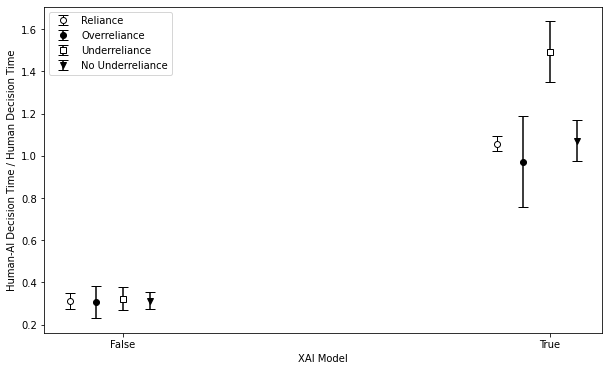

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
merged_data = pd.read_csv('mushroom_data/decision_times_reliance_groups.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

# AI
reliance_o_mean_ai = mean(reliance_o, 'human_ai_decision_time')
reliance_o_sem_ai = sem(reliance_o, 'human_ai_decision_time')
reliance_ox_mean_ai = mean(reliance_ox, 'human_ai_decision_time')
reliance_ox_sem_ai = sem(reliance_ox, 'human_ai_decision_time')

overreliance_o_mean_ai = mean(overreliance_o, 'human_ai_decision_time')
overreliance_o_sem_ai = sem(overreliance_o, 'human_ai_decision_time')
overreliance_ox_mean_ai = mean(overreliance_ox, 'human_ai_decision_time')
overreliance_ox_sem_ai = sem(overreliance_ox, 'human_ai_decision_time')

underreliance_o_mean_ai = mean(underreliance_o, 'human_ai_decision_time')
underreliance_o_sem_ai = sem(underreliance_o, 'human_ai_decision_time')
underreliance_ox_mean_ai = mean(underreliance_ox, 'human_ai_decision_time')
underreliance_ox_sem_ai = sem(underreliance_ox, 'human_ai_decision_time')

no_underreliance_o_mean_ai = mean(no_underreliance_o, 'human_ai_decision_time')
no_underreliance_o_sem_ai = sem(no_underreliance_o, 'human_ai_decision_time')
no_underreliance_ox_mean_ai = mean(no_underreliance_ox, 'human_ai_decision_time')
no_underreliance_ox_sem_ai = sem(no_underreliance_ox, 'human_ai_decision_time')

global_human_decision_time_o = np.array(global_results['human_decision_time_mean_0'])
global_human_decision_time_ox = np.array(global_results['human_decision_time_mean_1'])
global_human_decision_time_o_sem = np.array(global_results['human_decision_time_sem_0'])
global_human_decision_time_ox_sem = np.array(global_results['human_decision_time_sem_1'])

# SEM = X*sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)

normalized_reliance_sem_o = reliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (reliance_o_sem_ai/reliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_reliance_sem_ox = reliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (reliance_ox_sem_ai/reliance_ox_mean_ai)**2)/global_human_decision_time_ox)

print('Reliance O: ', normalized_reliance_sem_o)
print('Reliance OX: ', normalized_reliance_sem_ox)

normalized_overreliance_sem_o = overreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (overreliance_o_sem_ai/overreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_overreliance_sem_ox = overreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (overreliance_ox_sem_ai/overreliance_ox_mean_ai)**2)/global_human_decision_time_ox)

normalized_underreliance_sem_o = underreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (underreliance_o_sem_ai/underreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_underreliance_sem_ox = underreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (underreliance_ox_sem_ai/underreliance_ox_mean_ai)**2)/global_human_decision_time_ox)


normalized_no_underreliance_sem_o = no_underreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (no_underreliance_o_sem_ai/no_underreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_no_underreliance_sem_ox = no_underreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (no_underreliance_ox_sem_ai/no_underreliance_ox_mean_ai)**2)/global_human_decision_time_ox)

normalized_reliance_o = np.array(reliance_o_mean_ai/global_human_decision_time_o)
normalized_reliance_ox = np.array(reliance_ox_mean_ai/global_human_decision_time_ox)
normalized_overreliance_o = np.array(overreliance_o_mean_ai/global_human_decision_time_o)
normalized_overreliance_ox = np.array(overreliance_ox_mean_ai/global_human_decision_time_ox)
normalized_underreliance_o = np.array(underreliance_o_mean_ai/global_human_decision_time_o)
normalized_underreliance_ox = np.array(underreliance_ox_mean_ai/global_human_decision_time_ox)
normalized_no_underreliance_o = np.array(no_underreliance_o_mean_ai/global_human_decision_time_o)
normalized_no_underreliance_ox = np.array(no_underreliance_ox_mean_ai/global_human_decision_time_ox)

positions = [1.5, 9.5]
labels = ['False', 'True']

y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False

# convert to scalar values


normalized_reliance_sem_o = normalized_reliance_sem_o.item()
normalized_reliance_sem_ox = normalized_reliance_sem_ox.item()
normalized_reliance_o = normalized_reliance_o.item()
normalized_reliance_ox = normalized_reliance_ox.item()

plt.errorbar(y_index, [normalized_reliance_o, normalized_reliance_ox],\
                [normalized_reliance_sem_o, normalized_reliance_sem_ox], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, linewidth = 1, capthick=1, ecolor='black', label = 'Reliance')

print('Reliance O: ', normalized_reliance_o)
print('Reliance OX: ', normalized_reliance_ox)
print('SEM Reliance O: ', normalized_reliance_sem_o)
print('SEM Reliance OX: ', normalized_reliance_sem_ox)

# Overreliance in XAI = True and False

normalized_overreliance_sem_ox = normalized_overreliance_sem_ox.item()
normalized_overreliance_sem_o = normalized_overreliance_sem_o.item()
normalized_overreliance_o = normalized_overreliance_o.item()
normalized_overreliance_ox = normalized_overreliance_ox.item()


plt.errorbar(y_index_2, 
                [normalized_overreliance_o, normalized_overreliance_ox],\
                [normalized_overreliance_sem_o, normalized_overreliance_sem_ox], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

print('Overreliance O: ', normalized_overreliance_o)
print('Overreliance OX: ', normalized_overreliance_ox)
print('SEM Overreliance O: ', normalized_overreliance_sem_o)
print('SEM Overreliance OX: ', normalized_overreliance_sem_ox)

# Underreliance in XAI = True and False

normalized_underreliance_o = normalized_underreliance_o.item()
normalized_underreliance_ox = normalized_underreliance_ox.item()
normalized_underreliance_sem_o = normalized_underreliance_sem_o.item()
normalized_underreliance_sem_ox = normalized_underreliance_sem_ox.item()

plt.errorbar(y_index_3, 
                [normalized_underreliance_o, normalized_underreliance_ox],\
                [normalized_underreliance_sem_o, normalized_underreliance_sem_ox], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

print('Underreliance O: ', normalized_underreliance_o)
print('Underreliance OX: ', normalized_underreliance_ox)
print('SEM Underreliance O: ', normalized_underreliance_sem_o)
print('SEM Underreliance OX: ', normalized_underreliance_sem_ox)


# No Underreliance in XAI = True and False

normalized_no_underreliance_o = normalized_no_underreliance_o.item()
normalized_no_underreliance_ox = normalized_no_underreliance_ox.item()
normalized_no_underreliance_sem_o = normalized_no_underreliance_sem_o.item()
normalized_no_underreliance_sem_ox = normalized_no_underreliance_sem_ox.item()


plt.errorbar(y_index_4,
                [normalized_no_underreliance_o, normalized_no_underreliance_ox],\
                [normalized_no_underreliance_sem_o, normalized_no_underreliance_sem_ox], \
             markeredgecolor = 'black', color='black', marker = 'v', ls='none', capsize=5, capthick=1, ecolor='black', label = 'No Underreliance')

print('No Underreliance O: ', normalized_no_underreliance_o)
print('No Underreliance OX: ', normalized_no_underreliance_ox)
print('SEM No Underreliance O: ', normalized_no_underreliance_sem_o)
print('SEM No Underreliance OX: ', normalized_no_underreliance_sem_ox)

plt.legend()
plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('reliance_images/normalized_ai_decision_by_reliance_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.savefig('reliance_images/normalized_ai_decision_by_reliance_boxplot.svg', dpi = 1600, bbox_inches='tight')
plt.show()


